In [39]:
import gpxpy
import gpxpy.gpx
import numpy as np
import haversine as hs


import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [69]:
file_path = 'data/gpx/bear-trail.gpx'
with open(file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# * Get the number of data points (number of times geolocation was taken):
gpx.get_track_points_no()


1765

In [70]:
# Get the number of meters of uphil and downhil ride
# It's a roundtrip, so the numbers are almost identical
gpx.get_uphill_downhill()

UphillDownhill(uphill=4365.455200000002, downhill=4357.734199999997)

In [71]:
gpx.tracks[0]

GPXTrack(name='Bear Trail', segments=[GPXTrackSegment(points=[...])])

In [72]:
gpx.tracks[0].segments[0].points[:10]

[GPXTrackPoint(46.144479, 10.96529, elevation=891.346, time=datetime.datetime(2019, 5, 24, 15, 17, 29, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.151617, 10.960616, elevation=1354.788, time=datetime.datetime(2019, 5, 24, 15, 17, 49, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.151769, 10.960604, elevation=1359.516, time=datetime.datetime(2019, 5, 24, 15, 18, 9, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.151881, 10.960633, elevation=1375.008, time=datetime.datetime(2019, 5, 24, 15, 18, 29, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.151985, 10.960997, elevation=1375.027, time=datetime.datetime(2019, 5, 24, 15, 18, 49, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.151981, 10.961276, elevation=1371.04, time=datetime.datetime(2019, 5, 24, 15, 19, 9, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.152096, 10.961668, elevation=1367.051, time=datetime.datetime(2019, 5, 24, 15, 19, 29, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(46.152312, 10.962059, elevation=1367.013, time=datetime.datetime(2019, 5, 24, 15, 19, 4

In [73]:
route_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'altitude': point.elevation
            })
route_info[:3]

[{'time': datetime.datetime(2019, 5, 24, 15, 17, 29, tzinfo=SimpleTZ("Z")),
  'latitude': 46.144479,
  'longitude': 10.96529,
  'altitude': 891.346},
 {'time': datetime.datetime(2019, 5, 24, 15, 17, 49, tzinfo=SimpleTZ("Z")),
  'latitude': 46.151617,
  'longitude': 10.960616,
  'altitude': 1354.788},
 {'time': datetime.datetime(2019, 5, 24, 15, 18, 9, tzinfo=SimpleTZ("Z")),
  'latitude': 46.151769,
  'longitude': 10.960604,
  'altitude': 1359.516}]

In [74]:
route_df = pd.DataFrame(route_info)
route_df.head()

,time,latitude,longitude,altitude
0,2019-05-24 15:17:29+00:00,46.144479,10.965290,891.346
1,2019-05-24 15:17:49+00:00,46.151617,10.960616,1354.788
2,2019-05-24 15:18:09+00:00,46.151769,10.960604,1359.516
3,2019-05-24 15:18:29+00:00,46.151881,10.960633,1375.008
4,2019-05-24 15:18:49+00:00,46.151985,10.960997,1375.027


##### 3- Calculate altitude difference


In [75]:
route_df['altitude_diff'] = route_df['altitude'].diff()

route_df.head()

,time,latitude,longitude,altitude,altitude_diff
0,2019-05-24 15:17:29+00:00,46.144479,10.965290,891.346,NaN
1,2019-05-24 15:17:49+00:00,46.151617,10.960616,1354.788,463.442
2,2019-05-24 15:18:09+00:00,46.151769,10.960604,1359.516,4.728
3,2019-05-24 15:18:29+00:00,46.151881,10.960633,1375.008,15.492
4,2019-05-24 15:18:49+00:00,46.151985,10.960997,1375.027,0.019


In [76]:
def haversine_distance(lat1, lon1, lat2, lon2) -> float:
    distance = hs.haversine(
        point1=(lat1, lon1),
        point2=(lat2, lon2),
        unit=hs.Unit.METERS
    )
    return np.round(distance, 2)

Calculate the distances between all data points


In [77]:
haversine_distance(
    lat1=route_df.iloc[0]['latitude'],
    lon1=route_df.iloc[0]['longitude'],
    lat2=route_df.iloc[1]['latitude'],
    lon2=route_df.iloc[1]['longitude']
)

distances = [np.nan]
speed = [np.nan]

for i in range(1, len(route_df)):
    distances.append(haversine_distance(
        lat1=route_df.iloc[i - 1]['latitude'],
        lon1=route_df.iloc[i - 1]['longitude'],
        lat2=route_df.iloc[i]['latitude'],
        lon2=route_df.iloc[i]['longitude']
    ))

    # #* speed
    time_diff = (route_df.iloc[i].time - route_df.iloc[i - 1].time).seconds
    speed.append(distances[i]/time_diff)


route_df['distance'] = distances
route_df['speed'] = speed
route_df


,time,latitude,longitude,altitude,altitude_diff,distance,speed
0,2019-05-24 15:17:29+00:00,46.144479,10.965290,891.346,NaN,NaN,NaN
1,2019-05-24 15:17:49+00:00,46.151617,10.960616,1354.788,463.442,871.56,43.5780
2,2019-05-24 15:18:09+00:00,46.151769,10.960604,1359.516,4.728,16.93,0.8465
3,2019-05-24 15:18:29+00:00,46.151881,10.960633,1375.008,15.492,12.65,0.6325
4,2019-05-24 15:18:49+00:00,46.151985,10.960997,1375.027,0.019,30.33,1.5165
...,...,...,...,...,...,...,...
1760,2019-05-25 01:04:09+00:00,46.143240,10.964280,882.015,1.995,21.37,1.0685
1761,2019-05-25 01:04:29+00:00,46.143476,10.964383,888.096,6.081,27.42,1.3710
1762,2019-05-25 01:04:49+00:00,46.143630,10.964450,892.055,3.959,17.89,0.8945
1763,2019-05-25 01:05:09+00:00,46.143950,10.964650,898.096,6.041,38.78,1.9390


In [78]:
print('Max altitude:', (route_df['altitude']).max(), 'm')
# print('v', route_df[route_df['altitude_diff'] <= 0]['altitude_diff'].sum())

print('Total distance:', route_df['distance'].sum() / 1000, 'km')


Max altitude: 2117.105 m
Total distance: 59.67436 km


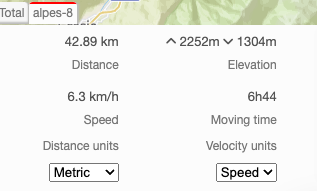

proof for <ins>alpes-8.gpx</ins>


##### Visualize the Elevation profile


In [79]:
route_df['relative_elevation'] = route_df['altitude_diff'].cumsum()
route_df['cum_distance'] = route_df['distance'].cumsum()/1e3

route_df = route_df.fillna(0)  # replace NANs with zero
route_df


,time,latitude,longitude,altitude,altitude_diff,distance,speed,relative_elevation,cum_distance
0,2019-05-24 15:17:29+00:00,46.144479,10.965290,891.346,0.000,0.00,0.0000,0.000,0.00000
1,2019-05-24 15:17:49+00:00,46.151617,10.960616,1354.788,463.442,871.56,43.5780,463.442,0.87156
2,2019-05-24 15:18:09+00:00,46.151769,10.960604,1359.516,4.728,16.93,0.8465,468.170,0.88849
3,2019-05-24 15:18:29+00:00,46.151881,10.960633,1375.008,15.492,12.65,0.6325,483.662,0.90114
4,2019-05-24 15:18:49+00:00,46.151985,10.960997,1375.027,0.019,30.33,1.5165,483.681,0.93147
...,...,...,...,...,...,...,...,...,...
1760,2019-05-25 01:04:09+00:00,46.143240,10.964280,882.015,1.995,21.37,1.0685,-9.331,59.57414
1761,2019-05-25 01:04:29+00:00,46.143476,10.964383,888.096,6.081,27.42,1.3710,-3.250,59.60156
1762,2019-05-25 01:04:49+00:00,46.143630,10.964450,892.055,3.959,17.89,0.8945,0.709,59.61945
1763,2019-05-25 01:05:09+00:00,46.143950,10.964650,898.096,6.041,38.78,1.9390,6.750,59.65823


In [80]:
def plot_route(df):
    plt.figure(figsize=(19, 3))
    plt.plot(df['cum_distance'] / 1000,
             df['altitude'], color='#101010', lw=3)
    plt.title('Route altitude profile', size=20)
    plt.xlabel('Distance in km', size=14)
    plt.ylabel('Altitude in meters', size=14)
    # plt.savefig('fig.jpg', dpi=300, bbox_inches='tight') # save the figure


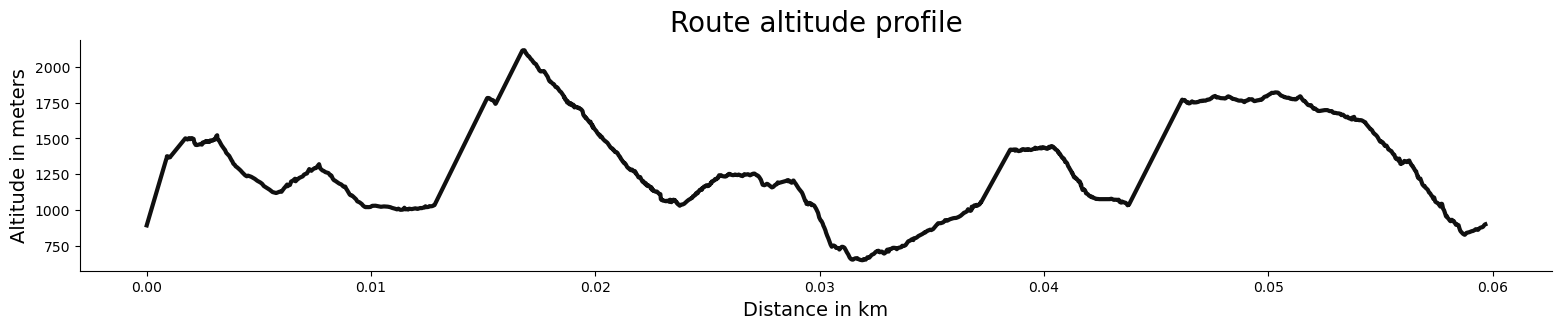

In [81]:
plot_route(route_df)

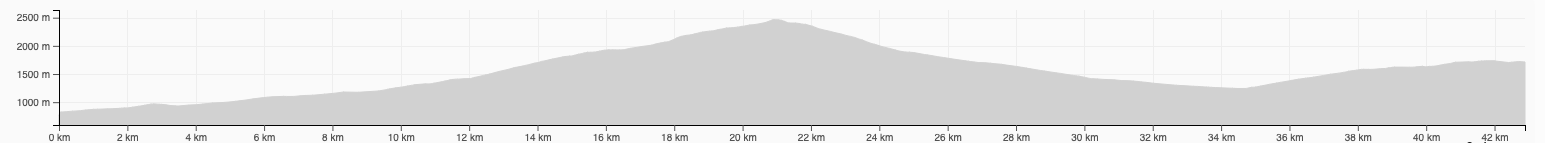


In [82]:
print('------------------speed---------------')
print(route_df['speed'].describe())
print('------------------distance---------------')
print(route_df['distance'].describe())

------------------speed---------------
count    1765.000000
mean        1.690492
std         4.747200
min         0.000000
25%         0.589000
50%         1.110500
75%         1.903500
max       117.791500
Name: speed, dtype: float64
------------------distance---------------
count    1765.000000
mean       33.809836
std        94.943994
min         0.000000
25%        11.780000
50%        22.210000
75%        38.070000
max      2355.830000
Name: distance, dtype: float64


In [89]:

number_of_lifts = 0
route_df['lift?'] = 0  # ? set the lift? column to zero
for i in range(len(route_df)):
    if route_df['altitude_diff'][i] > 100:
        # route_df['lift?'][i-1:i+1] = 1
        route_df.loc[i-1:i, 'lift?'] = 1

        number_of_lifts += 1
        print(route_df['altitude'][i])
        print('i', i)


number_of_lifts

1354.788
i 1
1500.068
i 10
1781.777
i 202
2114.167
i 213
1420.043
i 1042
1767.046
i 1240


6

In [90]:
# save the new df to csv
route_df.to_csv('./data/csv/' + file_path[9:-4] + '.csv', index=True)


In [85]:
# for i in range(1,len(route_df)):
#     time_diff = (route_df.iloc[i].time - route_df.iloc[i - 1].time).seconds/60
# print(time_diff)

total_time_in_min = (
    route_df.iloc[len(route_df)-1].time - route_df.iloc[0].time).seconds/60
total_time_in_min


588.0